# Comparing number of generated and reconstructed charged tracks

In this example, we compare the reconstructed charged track multiplicity to the truth-level generated multiplicity. This gives an indication of the efficiency with which tracks in the event are reconstructed.

In [20]:
import uproot4 as uproot
from fcc_python_tools.locations import loc
import matplotlib.pyplot as plt
import awkward1 as ak
from particle import literals as lp
from fcc_python_tools import plotting, kinematics
import numpy as np

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open("/eos/experiment/fcc/ee/tmp/test.root")
tree = file['events']

Get generated particles, and filter on the kaon, pion, muon, electron, and proton PDG IDs

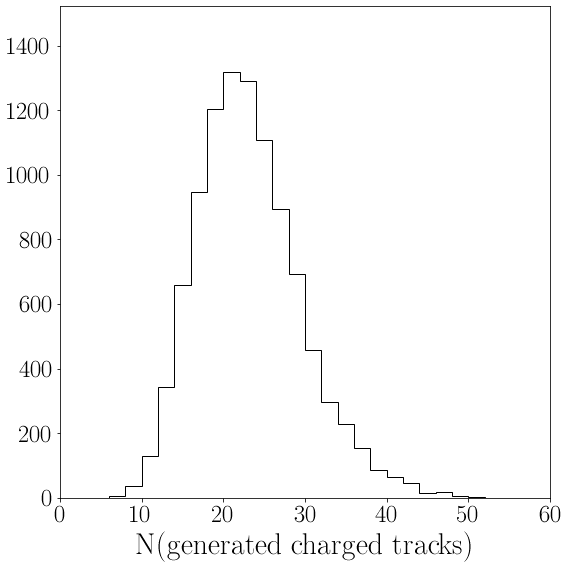

In [24]:
g_container = "Particle"
g = tree.arrays(filter_name=f"{g_container}*", how="zip")
g[g_container,'eta'] = kinematics.calc_eta(g,g_container)

#Apply eta cut to match the barrel detector cuts applied on reco particles
g_eta_cut = abs(g[g_container,'eta']) < 3
g = g[g_container][g_eta_cut]

p_list = {"mu": [abs(lp.mu_plus.pdgid), lp.mu_plus.mass], 
          "e": [abs(lp.e_plus.pdgid), lp.e_plus.mass], 
          "pi": [abs(lp.pi_plus.pdgid), lp.pi_plus.mass], 
          "k": [abs(lp.K_plus.pdgid), lp.K_plus.mass], 
          "p": [abs(lp.p.pdgid), lp.p.mass]
         }

n_gen = {}
for p in p_list:
    p_cut = abs(g['PDG']) == p_list[p][0]
    g_p = g[p_cut]
    n_gen[p] = ak.num(g_p)

n_gen_tot = n_gen["mu"] + n_gen["e"] + n_gen["pi"] + n_gen["k"] + n_gen["p"]

plotting.hist_plot(n_gen_tot,"n_gen","N(generated charged tracks)",0.,60.,30)

Same thing but for reconstructed muons, electrons, and hadrons

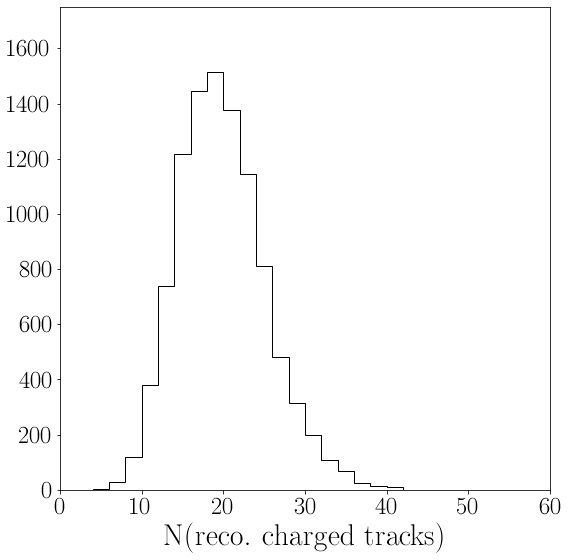

In [26]:
#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
r_container = "ReconstructedParticles"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)

r = tree.arrays(keep_vars,how="zip")

n_r = {}
for p in p_list:
    p_cut = abs(r[r_c,'mass'] - p_list[p][1]/1000.) < 1e-4
    r_p = r[r_c][p_cut]
    n_r[p] = ak.num(r_p)

n_r_tot = n_r["mu"] + n_r["e"] + n_r["pi"] + n_r["k"] + n_r["p"]

plotting.hist_plot(n_r_tot,"n_reco","N(reco. charged tracks)",0.,60.,30)

Calculate the fraction of reco charged tracks compared to generated:

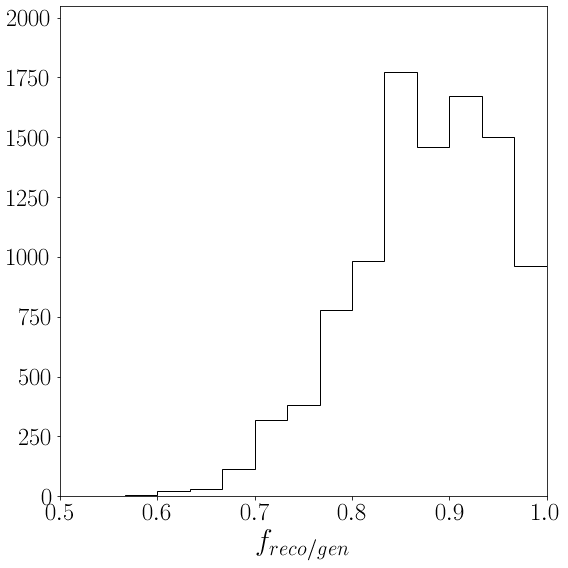

In [27]:
f = n_r_tot / n_gen_tot
plotting.hist_plot(f,"f_reco_gen","$f_{reco/gen}$",0.5,1.,15)

Check the reco fraction as a function of the true number of tracks in the event:

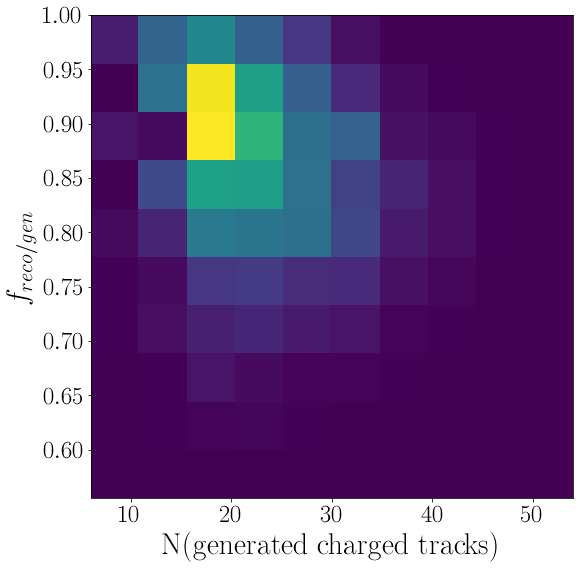

In [28]:
plotting.hist_plot_2d(n_gen_tot,
                      "n_gen",
                      "N(generated charged tracks)",
                      f,
                      "f_reco_gen",
                      "$f_{reco/gen}$",
                      np.min(n_gen_tot.tolist()),
                      np.max(n_gen_tot.tolist()),
                      np.min(f.tolist()),
                      np.max(f.tolist()),
                      10,
                      10,
                      False)